In [1]:
from pathlib import Path
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from ebm.probability import log_distributions, fit_distributions, predict_stage
from ebm.mcmc import greedy_ascent, mcmc, get_optimal_order

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the data

folder = Path('/data01/bgutman/MRI_data/PPMI/EBM_data/')
data = pd.read_csv(folder / 'corrected_ENIGMA-PD_Mixed_Effects_train_test_split.csv', index_col=0)
df = pd.read_csv(folder / 'ENIGMA-PD-regional.csv') # to merge with data, to obtain patients' metadata

train, test = train_test_split(data, stratify=data['cohort'], test_size=0.1, random_state=777)
X_train = train.drop(['SubjID', 'Dx', 'Sex', 'Age', 'cohort'], axis=1).values
y_train = train['Dx'].values
X_test = test.drop(['SubjID', 'Dx', 'Sex', 'Age', 'cohort'], axis=1).values
y_test = test['Dx'].values

# Precompute train, test probability distributions P(x| E), P(x| not E)

train_log_p_e, train_log_p_not_e = log_distributions(X_train, y_train)
test_log_p_e, test_log_p_not_e = log_distributions(X_train, y_train, X_test=X_test, y_test=y_test)

In [3]:
# Load results from MCMC run

# No connectivity prior
all_orders = np.load('../logs/order_mcmc.npy')
order_map, best_order = get_optimal_order(all_orders)

# With connectivity prior
all_orders_prior = np.load('../logs/prior_order_mcmc.npy')
order_map_prior, best_order_prior = get_optimal_order(all_orders_prior)

In [25]:
regions = ['_'.join(col.split('_')[:-1]) for col in test.drop(['SubjID', 'Dx', 'Sex', 'Age', 'cohort'], axis=1).columns]

In [4]:
best_order

array([43,  9,  6, 40, 61, 27, 23, 57, 29, 15, 22, 56, 36,  2, 60, 26, 25,
       20, 54, 63, 18, 16, 62, 28, 34, 13, 47, 41,  7, 59, 51, 52, 50, 44,
        0, 11, 32, 53,  3, 37, 45, 67, 49, 39, 66, 64, 17, 46, 12, 10, 30,
       33, 21, 55, 24, 42, 58,  8, 35,  4, 38, 31, 65, 48, 14,  1, 19,  5])

In [5]:
best_order_prior

array([43, 40,  6, 61, 27, 23, 57, 29, 15, 22, 56,  2, 36, 60, 26, 25, 20,
       54, 63, 18, 16, 62, 28, 13, 47,  7, 41,  5, 51, 59, 52, 17, 44, 46,
       50, 11,  0,  9, 34, 32, 53,  3, 19, 45, 37, 39, 66, 49, 30, 64, 10,
       12, 67, 33, 55, 24, 42,  8, 21, 58, 35,  4, 31, 65, 38, 48,  1, 14])

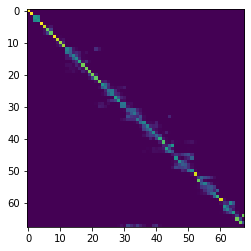

In [33]:
# plt.figure(figsize=(15,15))
plt.imshow(order_map[best_order]);#order_map_prior[best_order_prior])#
# plt.xticks(ticks=range(68),labels=regions, rotation=90);

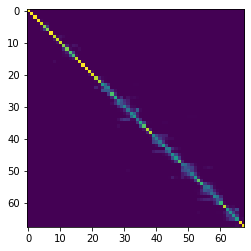

In [13]:
plt.imshow(order_map_prior[best_order_prior]);

## No prior

In [6]:
# Given optimal events order and probability distr. p(x| E), p(x| not E) computes
# optimale stage for input subjects

probas = predict_stage(best_order, train_log_p_e, train_log_p_not_e).T
stage = np.argmax(probas, axis=1)
train['pred_stage'] = stage

probas = predict_stage(best_order, test_log_p_e, test_log_p_not_e).T
stage = np.argmax(probas, axis=1)
test['pred_stage'] = stage

/home/kurmukov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/kurmukov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
train_stages = pd.merge(left=df[['SubjID', 'site', 'cohort', 'HY1234']], right=train, on='SubjID', how='right')
test_stages = pd.merge(left=df[['SubjID', 'site', 'cohort', 'HY1234']], right=test, on='SubjID', how='right')

In [8]:
train_stages.to_csv('/data01/bgutman/parkinson_ebm/train_parkinson_progression_stages.csv')
test_stages.to_csv('/data01/bgutman/parkinson_ebm/test_parkinson_progression_stages.csv')

## With prior

In [14]:
# Given optimal events order and probability distr. p(x| E), p(x| not E) computes
# optimale stage for input subjects

probas = predict_stage(best_order_prior, train_log_p_e, train_log_p_not_e).T
stage = np.argmax(probas, axis=1)
train['pred_stage'] = stage

probas = predict_stage(best_order_prior, test_log_p_e, test_log_p_not_e).T
stage = np.argmax(probas, axis=1)
test['pred_stage'] = stage

/home/kurmukov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/kurmukov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [15]:
train_stages = pd.merge(left=df[['SubjID', 'site', 'cohort', 'HY1234']], right=train, on='SubjID', how='right')
test_stages = pd.merge(left=df[['SubjID', 'site', 'cohort', 'HY1234']], right=test, on='SubjID', how='right')

In [16]:
train_stages.to_csv('/data01/bgutman/parkinson_ebm/train_parkinson_progression_stages_prior.csv')
test_stages.to_csv('/data01/bgutman/parkinson_ebm/test_parkinson_progression_stages_prior.csv')

# Some simple stats analysis

In [23]:
train_stages[['HY1234', 'Dx', 'pred_stage']].groupby('HY1234')['pred_stage'].agg(['median','mean', 'std', 'count'])

,median,mean,std,count
HY1234,,,,
0.0,40,39.161919,18.896610,667
1.0,40,38.918660,20.116203,209
2.0,42,40.654902,20.146480,510
3.0,42,41.033333,19.403687,120
4.0,37,35.343750,20.116771,32


In [22]:
test_stages[['HY1234', 'Dx', 'pred_stage']].groupby('HY1234')['pred_stage'].agg(['median','mean', 'std', 'count'])

,median,mean,std,count
HY1234,,,,
0.0,42.0,38.579710,20.462596,69
1.0,43.0,43.458333,15.396158,24
2.0,42.0,40.852459,19.888720,61
3.0,61.0,52.777778,14.420279,9
4.0,40.5,37.500000,27.061658,4


In [30]:
train_stages[['site','HY1234', 'Dx', 'pred_stage']].groupby(['site','HY1234'])['pred_stage'].agg(['median','mean', 'std', 'count'])

median       mean        std  count
site     HY1234                                     
Bern     0.0       44.0  42.357143  17.610725     42
         1.0       67.0  67.000000        NaN      1
         2.0       42.0  42.714286  20.510517     14
         3.0       53.5  46.200000  19.245779     10
         4.0       41.0  42.000000  19.165942      4
CGU      0.0       42.0  41.033613  18.769310    119
         1.0       38.0  37.500000  19.882991     40
         2.0       36.0  34.291667  18.045991     48
         3.0       38.0  40.296296  19.982328     27
         4.0       32.5  30.142857  22.145870     14
FSL      0.0       37.0  38.685714  16.802961     35
         1.0       40.0  37.500000  17.997222      6
         2.0       43.0  43.181818  17.676016     22
         3.0       27.0  27.000000   8.485281      2
GRAZ     0.0       37.0  38.194805  18.990329     77
         1.0       35.0  32.400000  24.217533     10
         2.0       48.0  41.508772  22.694495     57
         3.0       29.0  30.200000  21.580083      5
Liege1   0.0       41.0  37.117647  19.760701     17
         1.0       31.5  31.500000  44.547727      2
         2.0       38.0  36.800000  19.600454     10
         3.0       63.5  63.500000   2.121320      2
Liege2   0.0       27.0  28.111111  21.243377     18
         1.0       41.5  37.250000  22.801942      8
         2.0       23.5  23.000000  19.712215      8
         3.0       26.0  26.000000        NaN      1
Milan    0.0       34.0  27.800000  15.718354     10
         2.0       43.0  43.789474  16.913436     19
         3.0       61.5  49.750000  26.043233      4
Neurocon 0.0       50.5  42.000000  20.452034      8
...                 ...        ...        ...    ...
PPMI     2.0       42.5  42.087719  19.806838    114
         3.0       45.0  45.000000   2.828427      2
Penn     0.0       33.0  35.111111  17.891649      9
         1.0       54.5  54.500000   6.363961      2
         2.0       46.5  38.428571  22.859821     14
         3.0       43.0  41.500000  18.608086     24
Stanford 0.0       47.5  42.500000  16.379430      8
         2.0       47.0  43.454545  19.242472     11
         3.0       59.0  50.500000  21.252451      4
         4.0       21.0  21.000000        NaN      1
TaoWu    0.0       51.0  42.875000  19.231206      8
         1.0        2.5   2.500000   2.121320      2
         2.0       59.5  53.750000  15.219818      8
         3.0       49.0  49.000000        NaN      1
UNICAMP  0.0       41.0  36.398058  17.928146    103
         1.0       36.5  34.666667  16.014699     18
         2.0       27.0  23.772727  16.477782     22
         3.0       37.0  28.062500  20.243415     16
         4.0       39.0  37.800000   7.155418      5
UOMmain  0.0       37.0  40.400000  19.736840     15
         2.0       39.5  41.500000  19.017536      4
         3.0       59.0  55.000000   7.810250      3
         4.0       66.0  57.000000  15.588457      3
UOMpilot 0.0       29.0  29.250000   9.535023      4
         2.0       38.0  40.333333  18.610033      3
Udal     1.0       60.0  60.000000        NaN      1
         2.0       40.0  37.190476  22.429042     21
VUMC1    0.0       41.5  42.653846  18.395526     26
VUMC2    2.0       44.0  42.941176  19.181601     17
         3.0       49.0  49.000000   9.899495      2

[74 rows x 4 columns]

# compute expected stage instead of MAP

In [9]:
def compute_expectation(log_probabilities):
    expected = 0
    for s, p in zip(np.arange(68), np.exp(log_probabilities)):
        expected+= s*p
    return expected/np.exp(log_probabilities).sum()

def compute_all_expectations(all_log_probabilities):
    expected = []
    for subject in all_log_probabilities:
        expected.append(compute_expectation(subject))
    return expected

# TODO: compute stats. signific. t-test